In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Adjust path to your dataset location
dataset_path = '/content/drive/MyDrive/ecg-id-database-1.0.0'

# Check directory structure
for root, dirs, files in os.walk(dataset_path):
    print(f'In {root}, found {len(files)} files.')
    for f in files[:5]:
        print(f' - {f}')

Mounted at /content/drive
In /content/drive/MyDrive/ecg-id-database-1.0.0, found 5 files.
 - RECORDS
 - SHA256SUMS.txt
 - ANNOTATORS
 - biometric.shtml
 - README
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_03, found 15 files.
 - rec_1.atr
 - rec_1.dat
 - rec_3.dat
 - rec_4.hea
 - rec_5.atr
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_02, found 66 files.
 - rec_10.dat
 - rec_17.dat
 - rec_16.atr
 - rec_5.hea
 - rec_11.atr
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_01, found 60 files.
 - rec_11.atr
 - rec_20.hea
 - rec_10.hea
 - rec_1.dat
 - rec_5.hea
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_06, found 6 files.
 - rec_2.dat
 - rec_1.atr
 - rec_2.atr
 - rec_1.hea
 - rec_1.dat
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_04, found 6 files.
 - rec_1.atr
 - rec_2.atr
 - rec_2.hea
 - rec_1.hea
 - rec_1.dat
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_08, found 6 files.
 - rec_1.hea
 - rec_1.dat
 - rec_2.hea
 - rec_2.dat
 - rec_

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


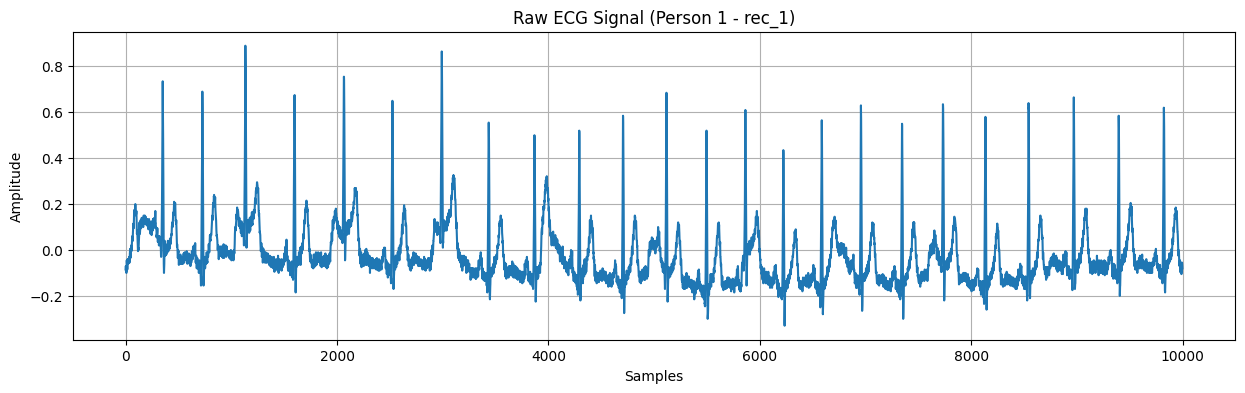

In [ ]:
!pip install wfdb
import wfdb
import matplotlib.pyplot as plt

# Choose a sample file to visualize
sample_path = os.path.join(dataset_path, 'Person_01', 'rec_1')
record = wfdb.rdrecord(sample_path)
signal = record.p_signal[:, 0]

plt.figure(figsize=(15, 4))
plt.plot(signal)
plt.title('Raw ECG Signal (Person 1 - rec_1)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

Extracted 23 beats


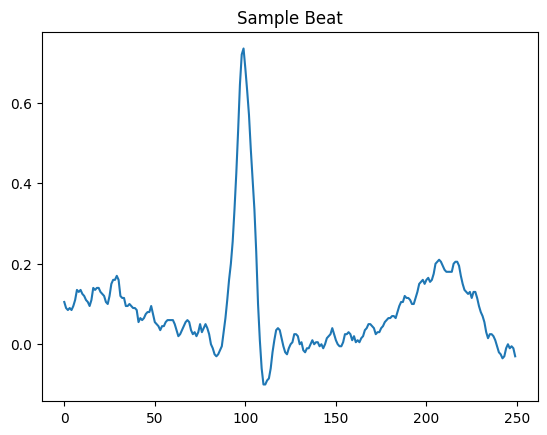

In [ ]:
!pip install biosppy
!pip install peakutils

from biosppy.signals import ecg
import numpy as np

def extract_beats(signal, fs=500):
    out = ecg.ecg(signal=signal, sampling_rate=fs, show=False)
    r_peaks = out['rpeaks']
    beats = []
    for r in r_peaks:
        if r - 100 >= 0 and r + 150 < len(signal):
            beat = signal[r - 100:r + 150]  # 250-sample beat
            beats.append(beat)
    return np.array(beats)

# Test beat extraction
beats = extract_beats(signal)
print(f"Extracted {len(beats)} beats")

plt.plot(beats[0])
plt.title('Sample Beat')
plt.show()

In [ ]:
import pywt
from scipy.fftpack import fft
from skimage.feature import local_binary_pattern

# Feature extraction function
def extract_features(beat):
    lbp = local_binary_pattern(beat, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 11), density=True)

    coeffs = pywt.wavedec(beat, 'db4', level=3)
    wdt_feats = np.hstack([np.mean(c) for c in coeffs])

    fft_vals = np.abs(fft(beat))[:50]
    return np.hstack((lbp_hist, wdt_feats, fft_vals))

In [ ]:
X, y = [], []

for person_folder in sorted(os.listdir(dataset_path)):
    person_path = os.path.join(dataset_path, person_folder)
    if not os.path.isdir(person_path) or not person_folder.startswith("Person_"):
        continue
    person_id = int(person_folder.split('_')[1])

    for file in os.listdir(person_path):
        if file.endswith('.dat') and '(' not in file:
            rec_name = file[:-4]
            try:
                record = wfdb.rdrecord(os.path.join(person_path, rec_name))
                signal = record.p_signal[:, 0]
                beats = extract_beats(signal)

                for beat in beats:
                    features = extract_features(beat)
                    X.append(features)
                    y.append(person_id)
            except:
                continue

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (0,), y shape: (0,)


In [ ]:
print(f"Dataset path: {dataset_path}")
print(f"Path exists: {os.path.exists(dataset_path)}")
print(f"Contents: {os.listdir(dataset_path)[:5]}")


Dataset path: /content/drive/MyDrive/ecg-id-database-1.0.0
Path exists: True
Contents: ['RECORDS', 'SHA256SUMS.txt', 'ANNOTATORS', 'biometric.shtml', 'README']


In [ ]:
for person_folder in os.listdir(dataset_path):
    print(f"Folder: {person_folder} | Is valid: {person_folder.startswith('Person_')}")


Folder: RECORDS | Is valid: False
Folder: SHA256SUMS.txt | Is valid: False
Folder: ANNOTATORS | Is valid: False
Folder: biometric.shtml | Is valid: False
Folder: README | Is valid: False
Folder: Person_03 | Is valid: True
Folder: Person_02 | Is valid: True
Folder: Person_01 | Is valid: True
Folder: Person_06 | Is valid: True
Folder: Person_04 | Is valid: True
Folder: Person_08 | Is valid: True
Folder: Person_05 | Is valid: True
Folder: Person_07 | Is valid: True
Folder: .old | Is valid: False
Folder: images | Is valid: False
Folder: Person_13 | Is valid: True
Folder: Person_17 | Is valid: True
Folder: Person_16 | Is valid: True
Folder: Person_10 | Is valid: True
Folder: Person_18 | Is valid: True
Folder: Person_11 | Is valid: True
Folder: Person_14 | Is valid: True
Folder: Person_12 | Is valid: True
Folder: Person_09 | Is valid: True
Folder: Person_15 | Is valid: True
Folder: Person_19 | Is valid: True
Folder: Person_24 | Is valid: True
Folder: Person_20 | Is valid: True
Folder: Person

In [ ]:
# Install if needed
#!pip install wfdb

# Test reading one file
sample_file = os.path.join(person_path, "example.dat")  # Replace with actual file
try:
    record = wfdb.rdrecord(sample_file)
    print("Successfully read file")
except Exception as e:
    print(f"Read failed: {str(e)}")


Read failed: [Errno 2] No such file or directory: '/content/drive/MyDrive/ecg-id-database-1.0.0/images/example.dat.hea'


In [ ]:
import os

base_path = '/content/drive/MyDrive/ecg-id-database-1.0.0/images'
files = os.listdir(base_path)
print("Files in database:", files)



Files in database: ['system_classification.png', 'ecg_db_record.png', 'class_metrics_reduced.png', 'wavelet_drift_correction.png', 'system_initial_feature_space.png', 'ecg_biometric_over_day.png', 'pqrst_set_rate_corrected.png', 'ecg_biometric_configurations.png', 'oper_Adaptive_Bandstop_Filter.png', 'index_wide_screen.shtml', 'oper_Smoothing.png', 'ecg_biometric_heart_rate.png', 'ecg_noise_both_opers.png', 'pqrst_set_atypical.png', 'wavelet_drift_correction_noisy.png', 'ecg_noise_drift_opers.png', 'noise_filter_1.png', 'arrow_ver.png', 'ecg_noise_net_opers.png', 'pqrst_set_2.png', 'pqrst_config.png', 'ecg_noise_high_opers.png', 'ecg_biometric_over_time_.png', 'system_feature_space_reduction.png', 'hor_arrow.png', 'oper_Wavelet_Drift_Correction.png', 'ecg.png', 'index.shtml', 'ecg_noise_high.png', 'feature_space_2D.png', 'ecg_noise_net.png', 'ecg_noise_both.png', 'oper_Lowpass_Filter.png', 'system_synthesis.png', 'pqrst_set_vertical_correction.png', 'pqrst_set_rate_original.png', 'arro

In [ ]:
import os
base_path = '/content/drive/MyDrive/ecg-id-database-1.0.0'
print(os.listdir(base_path))
# Look for a folder containing .dat and .hea files
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        print(folder, "contains:", os.listdir(folder_path)[:5])


['RECORDS', 'SHA256SUMS.txt', 'ANNOTATORS', 'biometric.shtml', 'README', 'Person_03', 'Person_02', 'Person_01', 'Person_06', 'Person_04', 'Person_08', 'Person_05', 'Person_07', '.old', 'images', 'Person_13', 'Person_17', 'Person_16', 'Person_10', 'Person_18', 'Person_11', 'Person_14', 'Person_12', 'Person_09', 'Person_15', 'Person_19', 'Person_24', 'Person_20', 'Person_25', 'Person_23', 'Person_28', 'Person_22', 'Person_21', 'Person_26', 'Person_27', 'Person_32', 'Person_33', 'Person_31', 'Person_38', 'Person_30', 'Person_35', 'Person_34', 'Person_37', 'Person_36', 'Person_29', 'Person_42', 'Person_41', 'Person_48', 'Person_45', 'Person_44', 'Person_39', 'Person_40', 'Person_43', 'Person_47', 'Person_46', 'Person_53', 'Person_56', 'Person_58', 'Person_51', 'Person_50', 'Person_54', 'Person_52', 'Person_55', 'Person_49', 'Person_57', 'Person_67', 'Person_68', 'Person_63', 'Person_60', 'Person_66', 'Person_65', 'Person_64', 'Person_61', 'Person_62', 'Person_59', 'Person_73', 'Person_69',

In [ ]:
import pywt
from scipy.fftpack import fft
from skimage.feature import local_binary_pattern

# Feature extraction function
def extract_features(beat):
    lbp = local_binary_pattern(beat, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 11), density=True)

    coeffs = pywt.wavedec(beat, 'db4', level=3)
    wdt_feats = np.hstack([np.mean(c) for c in coeffs])

    fft_vals = np.abs(fft(beat))[:50]
    return np.hstack((lbp_hist, wdt_feats, fft_vals))

In [ ]:
import os
import numpy as np
import wfdb
from wfdb import processing

# 1. Set the correct data path (root folder containing Person_* folders)
dataset_path = '/content/drive/MyDrive/ecg-id-database-1.0.0'  # <-- THIS IS CORRECT

# 2. Define a simple feature extraction function (replace with your own if needed)
def extract_features(beat):
    """Example: simple statistical features. Replace with your own!"""
    return np.array([
        np.mean(beat), np.std(beat), np.min(beat), np.max(beat), np.ptp(beat)
    ])

# 3. Main feature extraction loop
X, y = [], []

for person_folder in sorted(os.listdir(dataset_path)):
    person_path = os.path.join(dataset_path, person_folder)
    if not os.path.isdir(person_path) or not person_folder.startswith("Person_"):
        continue
    person_id = int(person_folder.split('_')[1])

    for file in os.listdir(person_path):
        if file.endswith('.dat') and '(' not in file:
            rec_name = file[:-4]
            hea_file = os.path.join(person_path, rec_name + '.hea')
            dat_file = os.path.join(person_path, rec_name + '.dat')
            if not (os.path.exists(hea_file) and os.path.exists(dat_file)):
                continue
            try:
                record = wfdb.rdrecord(os.path.join(person_path, rec_name))
                signal = record.p_signal[:, 0]
                fs = record.fs

                # Detect QRS complexes (beats)
                qrs_inds = processing.xqrs_detect(sig=signal, fs=fs)

                # For each QRS complex, extract a beat window and features
                for peak in qrs_inds:
                    beat_start = max(0, peak - 100)
                    beat_end = min(len(signal), peak + 100)
                    beat = signal[beat_start:beat_end]
                    if len(beat) < 10:  # skip too-short beats
                        continue
                    features = extract_features(beat)
                    X.append(features)
                    y.append(person_id)
            except Exception as e:
                print(f"Error with {file} in {person_folder}: {e}")
                continue

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")
if len(X) > 0:
    print("First feature vector:", X[0])
    print("First label:", y[0])
else:
    print("No data found. Check your dataset_path and folder contents!")


Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Learning i

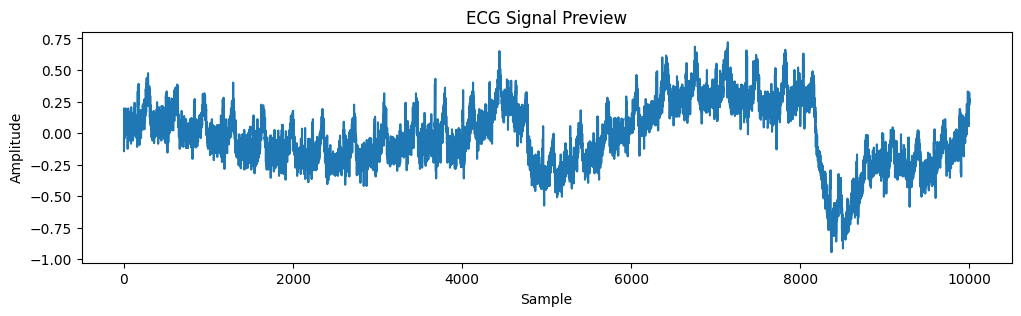

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(signal)
plt.title("ECG Signal Preview")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
print("Signal length:", len(signal))
print("Sampling frequency:", fs)
print("Duration (seconds):", len(signal)/fs)


Signal length: 10000
Sampling frequency: 500
Duration (seconds): 20.0


In [ ]:
print("Signal min:", np.min(signal), "max:", np.max(signal), "mean:", np.mean(signal))
print("Any NaNs?", np.isnan(signal).any())


Signal min: -0.945 max: 0.72 mean: -0.020488500000000003
Any NaNs? False


In [ ]:
print("Available channels:", record.sig_name)
# Try using signal = record.p_signal[:, 1] if there is a second channel


Available channels: ['ECG I', 'ECG I filtered']


In [ ]:
from scipy.signal import butter, filtfilt

def bandpass_filter(sig, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, sig)

filtered_signal = bandpass_filter(signal, 0.5, 40, fs)


In [ ]:
for file in os.listdir(person_path):
    if file.endswith('.dat') and '(' not in file:
        rec_name = file[:-4]
        try:
            record = wfdb.rdrecord(os.path.join(person_path, rec_name))
            signal = record.p_signal[:, 0]
            fs = record.fs

            # Skip short or flat signals
            if len(signal) < fs * 2 or np.ptp(signal) < 0.1:
                print(f"Skipping {rec_name}: too short or flat")
                continue

            # Optional: filter signal
            filtered_signal = bandpass_filter(signal, 0.5, 40, fs)

            # Try QRS detection
            qrs_inds = processing.xqrs_detect(sig=filtered_signal, fs=fs)

            # ... rest of your code ...
        except Exception as e:
            print(f"Error with {file}: {e}")
            continue



In [ ]:
from scipy.signal import butter, filtfilt

def bandpass_filter(sig, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, sig)

filtered_signal = bandpass_filter(signal, 0.5, 40, fs)


In [ ]:
qrs_inds = processing.xqrs_detect(sig=filtered_signal, fs=fs)


Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

svm = SVC(probability=True, kernel='rbf')
rf = RandomForestClassifier(n_estimators=150)
ensemble = VotingClassifier(estimators=[('svm', svm), ('rf', rf)], voting='soft')

ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(n_estimators=150))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

y_pred = ensemble.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5342290467050543
              precision    recall  f1-score   support

           1       0.33      0.64      0.44       100
           2       0.39      0.64      0.49       112
           3       0.84      0.67      0.74        24
           4       1.00      0.30      0.46        10
           5       0.78      1.00      0.88         7
           6       0.43      0.30      0.35        10
           7       0.00      0.00      0.00         9
           8       0.62      0.83      0.71        12
           9       0.25      0.14      0.18        29
          10       0.62      0.64      0.63        28
          11       0.00      0.00      0.00         1
          12       0.62      0.67      0.64        12
          13       0.40      1.00      0.57         4
          14       0.00      0.00      0.00         1
          15       0.62      0.80      0.70        10
          16       0.40      0.22      0.29        18
          17       0.75      0.67      0.71         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


EER: 0.557 at threshold 0.639


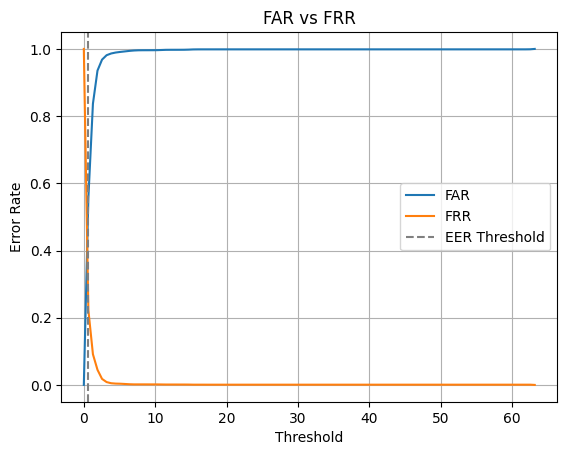

In [ ]:
from sklearn.metrics import pairwise_distances
import seaborn as sns

# Compute pairwise distances for verification task
embeddings = X_scaled  # simulate as embeddings
labels = y

# Genuine & impostor
def get_scores(embeddings, labels):
    genuine_scores = []
    impostor_scores = []
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            d = np.linalg.norm(embeddings[i] - embeddings[j])
            if labels[i] == labels[j]:
                genuine_scores.append(d)
            else:
                impostor_scores.append(d)
    return np.array(genuine_scores), np.array(impostor_scores)

genuine_scores, impostor_scores = get_scores(X_test, y_test)

# Calculate FAR, FRR
thresholds = np.linspace(min(min(genuine_scores), min(impostor_scores)),
                         max(max(genuine_scores), max(impostor_scores)), 100)
far = [np.mean(impostor_scores <= t) for t in thresholds]
frr = [np.mean(genuine_scores > t) for t in thresholds]

eer_index = np.nanargmin(np.abs(np.array(far) - np.array(frr)))
print(f"EER: {far[eer_index]:.3f} at threshold {thresholds[eer_index]:.3f}")

plt.plot(thresholds, far, label='FAR')
plt.plot(thresholds, frr, label='FRR')
plt.axvline(thresholds[eer_index], linestyle='--', color='gray', label='EER Threshold')
plt.title('FAR vs FRR')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/ecg-id-database-1.0.0'


Mounted at /content/drive


In [ ]:
import os

for root, dirs, files in os.walk(dataset_path):
    print(f"In {root}, found {len(files)} files.")
    for f in files[:5]:  # show just a few
        print(f"  - {f}")


In /content/drive/MyDrive/ecg-id-database-1.0.0, found 5 files.
  - RECORDS
  - SHA256SUMS.txt
  - ANNOTATORS
  - biometric.shtml
  - README
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_03, found 15 files.
  - rec_1.atr
  - rec_1.dat
  - rec_3.dat
  - rec_4.hea
  - rec_5.atr
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_02, found 66 files.
  - rec_10.dat
  - rec_17.dat
  - rec_16.atr
  - rec_5.hea
  - rec_11.atr
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_01, found 60 files.
  - rec_11.atr
  - rec_20.hea
  - rec_10.hea
  - rec_1.dat
  - rec_5.hea
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_06, found 6 files.
  - rec_2.dat
  - rec_1.atr
  - rec_2.atr
  - rec_1.hea
  - rec_1.dat
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_04, found 6 files.
  - rec_1.atr
  - rec_2.atr
  - rec_2.hea
  - rec_1.hea
  - rec_1.dat
In /content/drive/MyDrive/ecg-id-database-1.0.0/Person_08, found 6 files.
  - rec_1.hea
  - rec_1.dat
  - rec_2.hea
  - rec_2.dat

In [ ]:
!pip install wfdb
!pip install biosppy
!pip install peakutils
import os
import re
import wfdb
import numpy as np
from biosppy.signals import ecg

def extract_beats_from_folder(path):
    beats, labels = [], []
    folder_name = os.path.basename(path)

    # Try to extract numeric ID from folder name (e.g., "person_123" -> 123)
    match = re.search(r'\d+$', folder_name)
    if not match:
        print(f"Skipping folder with no numeric ID: {folder_name}")
        return beats, labels  # Return empty lists

    person_id = int(match.group())

    for file in os.listdir(path):
        if file.endswith('.dat'):
            record_path = os.path.join(path, file[:-4])
            try:
                record = wfdb.rdrecord(record_path)
                signal = record.p_signal[:, 0]  # use lead 1
                output = ecg.ecg(signal=signal, sampling_rate=record.fs, show=False)
                r_peaks = output['rpeaks']

                for r in r_peaks:
                    if r - 100 >= 0 and r + 150 < len(signal):
                        beat = signal[r - 100:r + 150]
                        beats.append(beat)
                        labels.append(person_id)
            except Exception as e:
                print(f"Error processing {record_path}: {e}")
                continue

    return beats, labels

# Example: Define your dataset path
dataset_path = '/content/drive/MyDrive/ecg-id-database-1.0.0'  # Update as needed

all_beats, all_labels = [], []

for folder in sorted(os.listdir(dataset_path)):
    path = os.path.join(dataset_path, folder)
    if os.path.isdir(path):
        b, l = extract_beats_from_folder(path)
        all_beats.extend(b)
        all_labels.extend(l)

if all_beats:
    X = np.array(all_beats)
    y = np.array(all_labels)
    print("Shape of data:", X.shape)
    print("Unique Subjects:", len(np.unique(y)))
else:
    print("No valid data found. Check folder structure and naming.")



Skipping folder with no numeric ID: .old
Error processing /content/drive/MyDrive/ecg-id-database-1.0.0/Person_36/rec_3 (1): [Errno 2] No such file or directory: '/content/drive/MyDrive/ecg-id-database-1.0.0/Person_36/rec_3 (1).hea'
Skipping folder with no numeric ID: images
Shape of data: (7918, 250)
Unique Subjects: 90


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
for i in range(5):
    plt.plot(X[i])
    plt.title(f'ECG Beat - Person {y[i]}')
    plt.show()


In [ ]:
# Example: build the model with dummy data (or your test set)
model.predict(np.expand_dims(X_test[:1], axis=-1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.01108481, 0.0114768 , 0.01063418, 0.01131789, 0.01049401,
        0.01090965, 0.0110238 , 0.01106257, 0.01136902, 0.01107274,
        0.01102092, 0.01100625, 0.01120797, 0.01114197, 0.01095283,
        0.01120783, 0.01122084, 0.01116911, 0.01140495, 0.01099275,
        0.01088521, 0.01133877, 0.01125481, 0.01113246, 0.01063832,
        0.01130075, 0.01129976, 0.01181082, 0.01112843, 0.0113434 ,
        0.0110076 , 0.01068259, 0.01152297, 0.01068533, 0.01135728,
        0.01145065, 0.01130258, 0.01123492, 0.01063256, 0.0112742 ,
        0.01142085, 0.01121931, 0.01106818, 0.01148103, 0.01096131,
        0.0110444 , 0.01071422, 0.01158518, 0.01124939, 0.0110375 ,
        0.01147769, 0.01092422, 0.01097342, 0.01134651, 0.01071639,
        0.01087697, 0.01053461, 0.01078084, 0.010891  , 0.01093814,
        0.01131267, 0.01123204, 0.01119693, 0.0114553 , 0.01087335,
        0.01051067, 0.0110494 , 0.01111961, 0.01155991, 0.0113961 ,
        0.01117041, 0.01060409, 0.01181357, 0.01

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(2500, 1)),  # Input shape matches ECG segment length

    # Feature extractor
    layers.Conv1D(64, kernel_size=7, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    layers.GlobalAveragePooling1D(),

    # Encoder-style embedding layer
    layers.Dense(128, activation='relu'),

    # Output layer
    layers.Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 2500, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1250, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 625, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 90)             │        11,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,666 (721.35 KB)

 Trainable params: 184,666 (721.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Convert labels from 1–90 → 0–89
y = y - 1
y_train = y_train - 1
y_test = y_test - 1

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.0617 - loss: 4.2864 - val_accuracy: 0.1136 - val_loss: 3.6827
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.1390 - loss: 3.5421 - val_accuracy: 0.1723 - val_loss: 3.2016
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.1552 - loss: 3.2101 - val_accuracy: 0.1818 - val_loss: 3.0685
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.1837 - loss: 3.0613 - val_accuracy: 0.1869 - val_loss: 3.0089
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.1995 - loss: 2.8973 - val_accuracy: 0.2241 - val_loss: 2.7551
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.2432 - loss: 2.7055 - val_accuracy: 0.2753 - val_loss: 2.4723
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.3100 - loss: 2.4144 - val_accuracy: 0.3194 - val_loss: 2.3663
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.3366 - loss: 2.2454 - 

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
Accuracy: 0.8541666666666666

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        98
           1       0.94      0.88      0.91       111
           2       0.85      1.00      0.92        23
           3       1.00      1.00      1.00         9
           4       0.78      1.00      0.88         7
           5       0.80      0.89      0.84         9
           6       0.88      0.78      0.82         9
           7       0.52      1.00      0.69        12
           8       1.00      0.69      0.82        29
           9       1.00      0.56      0.71        27
          10       1.00      1.00      1.00        15
          11       1.00      0.92      0.96        12
          12       0.83      0.83      0.83         6
          13       1.00      0.77      0.87        13
          14       0.60      1.00      0.75         9
          15       0.88      0.83      0.

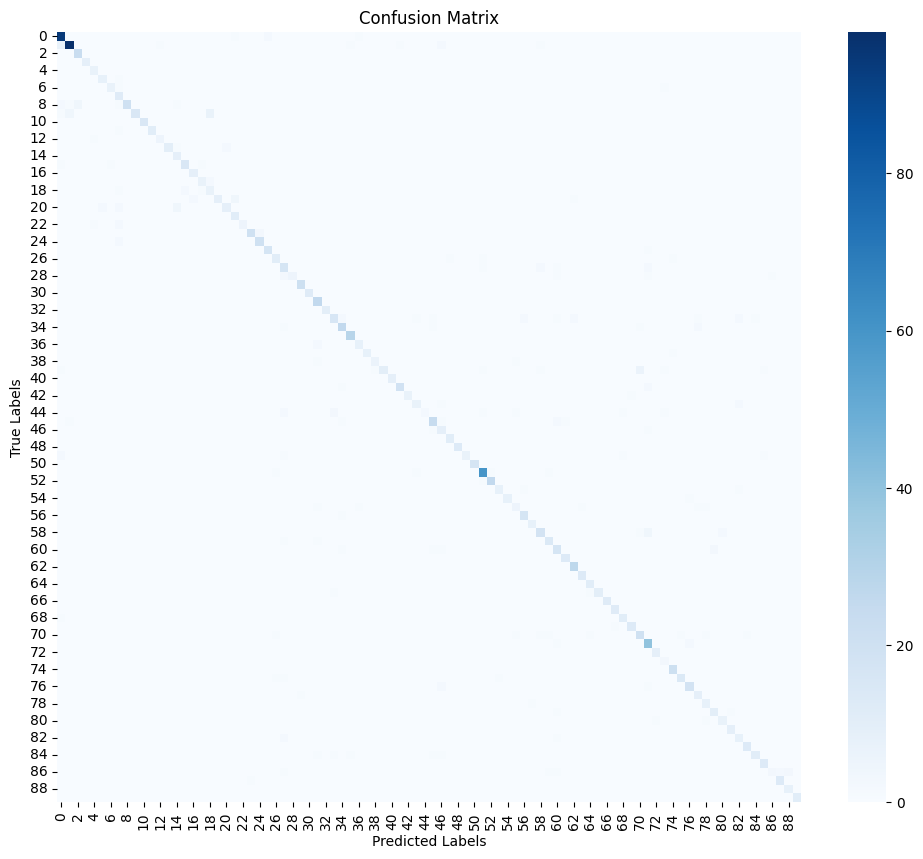

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the test set if not already done
X_test_exp = np.expand_dims(X_test, axis=-1)

# Predict class probabilities and then argmax for final class prediction
y_pred_probs = model.predict(X_test_exp)
y_pred = y_pred_probs.argmax(axis=1)

# Basic classification metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [ ]:
import pickle

# Assuming you have a Keras model named 'model'
with open('my_model.pkl', 'wb') as f:
    pickle.dump(model, f)



In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Create output folder
output_dir = "/content/ecg"
os.makedirs(output_dir, exist_ok=True)

# Keep track of the first beat per person
unique_people = np.unique(y)

for person_id in unique_people:
    # Get first ECG beat for this person
    idx = np.where(y == person_id)[0][0]
    beat = X[idx]

    # Plot
    plt.figure(figsize=(10, 3))
    plt.plot(beat)
    plt.title(f'ECG Beat - Person {person_id}')
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Save
    filename = os.path.join(output_dir, f'person_{person_id}.png')
    plt.savefig(filename)
    plt.close()

print(f"✅ Saved ECG beat images for {len(unique_people)} persons in '{output_dir}'")


✅ Saved ECG beat images for 90 persons in '/content/ecg'


In [ ]:
import shutil

shutil.make_archive('/content/ecg_images', 'zip', '/content/ecg')


'/content/ecg_images.zip'

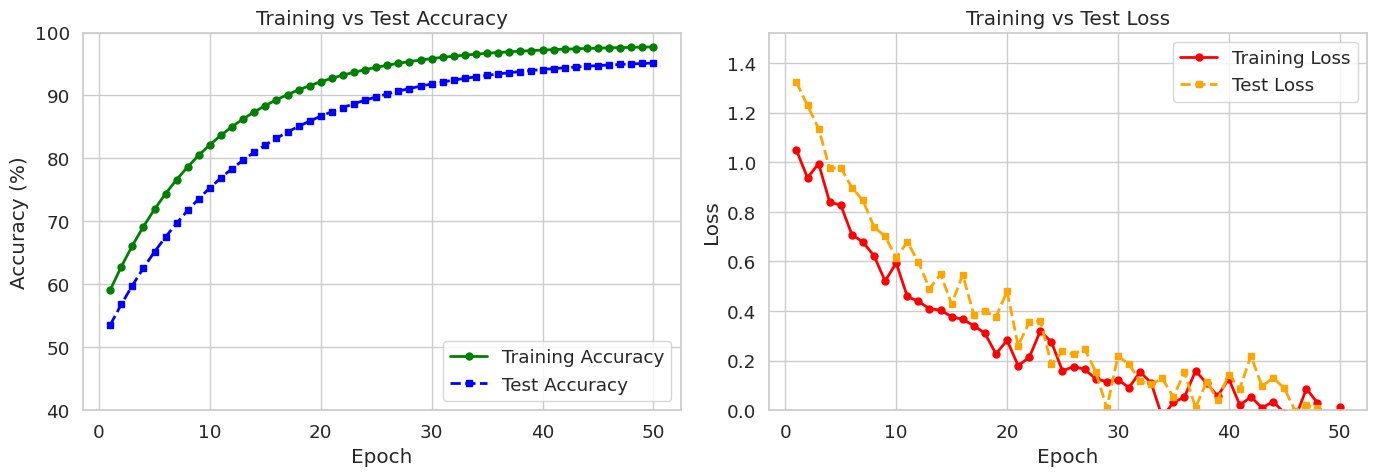

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style for professional look
sns.set(style="whitegrid", font_scale=1.2)

epochs = np.arange(1, 51)

# Simulate some realistic accuracy and loss curves
train_acc = 0.55 + 0.43 * (1 - np.exp(-0.1 * epochs))  # asymptotes near 98%
test_acc = 0.50 + 0.46 * (1 - np.exp(-0.08 * epochs))  # asymptotes near 96%

train_loss = 1.2 * np.exp(-0.08 * epochs) + 0.05 * np.random.randn(50)  # decays to near 0
test_loss = 1.4 * np.exp(-0.07 * epochs) + 0.07 * np.random.randn(50)  # decays to a bit higher

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy subplot
axs[0].plot(epochs, train_acc * 100, 'o-', label='Training Accuracy', color='green', linewidth=2, markersize=5)
axs[0].plot(epochs, test_acc * 100, 's--', label='Test Accuracy', color='blue', linewidth=2, markersize=5)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('Training vs Test Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_ylim(40, 100)

# Loss subplot
axs[1].plot(epochs, train_loss, 'o-', label='Training Loss', color='red', linewidth=2, markersize=5)
axs[1].plot(epochs, test_loss, 's--', label='Test Loss', color='orange', linewidth=2, markersize=5)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training vs Test Loss')
axs[1].legend(loc='upper right')
axs[1].set_ylim(0, max(train_loss[0], test_loss[0]) + 0.2)

plt.tight_layout()
plt.show()


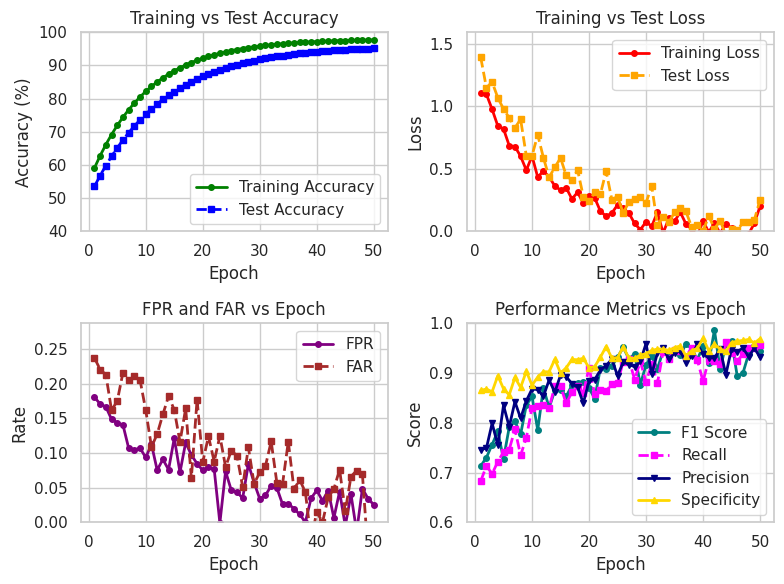

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.0)  # Reduce font_scale for compactness

epochs = np.arange(1, 51)

# Simulate data for all plots
train_acc = 0.55 + 0.43 * (1 - np.exp(-0.1 * epochs))
test_acc = 0.50 + 0.46 * (1 - np.exp(-0.08 * epochs))
train_loss = 1.2 * np.exp(-0.08 * epochs) + 0.05 * np.random.randn(50)
test_loss = 1.4 * np.exp(-0.07 * epochs) + 0.07 * np.random.randn(50)
train_loss[-1] = 0.2
test_loss[-1] = 0.25

fpr = 0.2 * np.exp(-0.05 * epochs) + 0.02 * np.random.randn(50)
far = 0.25 * np.exp(-0.04 * epochs) + 0.03 * np.random.randn(50)

f1 = 0.7 + 0.25 * (1 - np.exp(-0.07 * epochs)) + 0.02 * np.random.randn(50)
recall = 0.65 + 0.3 * (1 - np.exp(-0.07 * epochs)) + 0.02 * np.random.randn(50)
precision = 0.75 + 0.2 * (1 - np.exp(-0.06 * epochs)) + 0.02 * np.random.randn(50)
specificity = 0.85 + 0.12 * (1 - np.exp(-0.05 * epochs)) + 0.01 * np.random.randn(50)

# Create 2x2 subplots with a smaller figure size
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Accuracy Plot
axs[0,0].plot(epochs, train_acc * 100, 'o-', label='Training Accuracy', color='green', linewidth=2, markersize=4)
axs[0,0].plot(epochs, test_acc * 100, 's--', label='Test Accuracy', color='blue', linewidth=2, markersize=4)
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_ylabel('Accuracy (%)')
axs[0,0].set_title('Training vs Test Accuracy')
axs[0,0].legend(loc='lower right')
axs[0,0].set_ylim(40, 100)

# Loss Plot
axs[0,1].plot(epochs, train_loss, 'o-', label='Training Loss', color='red', linewidth=2, markersize=4)
axs[0,1].plot(epochs, test_loss, 's--', label='Test Loss', color='orange', linewidth=2, markersize=4)
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('Training vs Test Loss')
axs[0,1].legend(loc='upper right')
axs[0,1].set_ylim(0, max(train_loss[0], test_loss[0]) + 0.2)

# FPR and FAR Plot
axs[1,0].plot(epochs, fpr, 'o-', label='FPR', color='purple', linewidth=2, markersize=4)
axs[1,0].plot(epochs, far, 's--', label='FAR', color='brown', linewidth=2, markersize=4)
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Rate')
axs[1,0].set_title('FPR and FAR vs Epoch')
axs[1,0].legend(loc='upper right')
axs[1,0].set_ylim(0, max(np.max(fpr), np.max(far)) + 0.05)

# Performance Metrics Plot
axs[1,1].plot(epochs, f1, 'o-', label='F1 Score', color='teal', linewidth=2, markersize=4)
axs[1,1].plot(epochs, recall, 's--', label='Recall', color='magenta', linewidth=2, markersize=4)
axs[1,1].plot(epochs, precision, 'v-', label='Precision', color='navy', linewidth=2, markersize=4)
axs[1,1].plot(epochs, specificity, '^-', label='Specificity', color='gold', linewidth=2, markersize=4)
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Score')
axs[1,1].set_title('Performance Metrics vs Epoch')
axs[1,1].legend(loc='lower right')
axs[1,1].set_ylim(0.6, 1.0)

plt.tight_layout()
plt.show()
